In [1]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from scipy.spatial import distance
from skimage import exposure, filters, io, morphology
from skimage.color import rgb2gray


 # Projekt

 ##### Wczytanie obrazu i wyliczenie histogramu

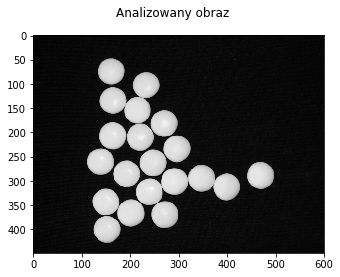

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


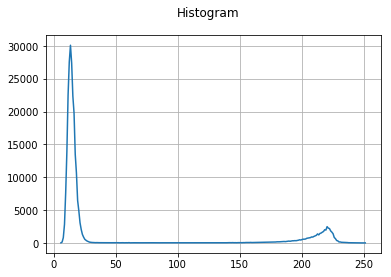

In [2]:

path = './images/'
img = io.imread(path + 'img14.png')

image = rgb2gray(img)


def plot_hist(image, title):
    hist, bins = exposure.histogram(image)
    plt.plot(255*bins, hist)
    plt.suptitle(title)
    plt.grid('on')
    plt.show()


plt.imshow(image, cmap='gray')
plt.axis('on')
plt.suptitle('Analizowany obraz')
plt.show()

plot_hist(image, 'Histogram')


 ##### Binaryzacja

Prog binaryzacji:  0.43779128753063723


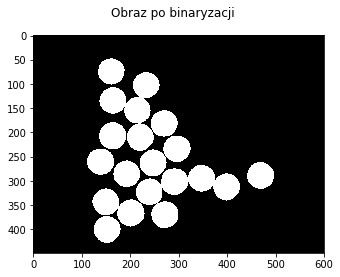

In [3]:
th = filters.threshold_isodata(image)
print('Prog binaryzacji: ', th)
binary = image > th

plt.imshow(binary, cmap='gray')
plt.axis('on')
plt.suptitle('Obraz po binaryzacji')
plt.show()


 ##### Objętość obiektów na obrazie (przed erozją)

In [4]:
label_objects, nb_labels = ndi.label(binary)


def getFigure(labelledImage, objNumber):

    points = []
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y, x] == objNumber:
                points.append((y, x))

    return points


number_of_points = 0

for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    number_of_points += len(pts)

print('Wszystkich punktów:', str((image.shape[0]*(image.shape[1]))))
print('Punkty należące do obiektów:', str(number_of_points))
print('Zawartość procentowa obiektów na obrazie: ', number_of_points /
      (label_objects.shape[0]*(label_objects.shape[1]))*100, '%')


Wszystkich punktów: 269400
Punkty należące do obiektów: 47624
Zawartość procentowa obiektów na obrazie:  17.677802524127692 %


 ##### Erozja, wypełnienie luk, usunięcie małych elementów i rozpoznanie obiektów na obrazie

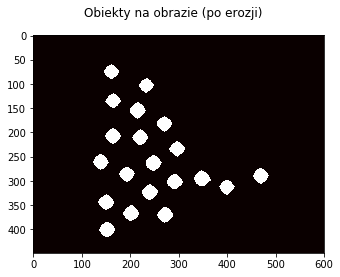

Rozmiar maski: (449, 600)
Rozmiar obrazu: (449, 600)
Ilość obiektów: 20


In [5]:
erosion = morphology.binary_erosion(np.copy(binary), morphology.square(20))

fill = ndi.binary_fill_holes(erosion)
objects = morphology.remove_small_objects(fill, 200)

label_objects, nb_labels = ndi.label(objects)

sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0

figures = mask_sizes[label_objects]

plt.imshow(figures, cmap="hot")
plt.axis('on')
plt.suptitle('Obiekty na obrazie (po erozji)')
plt.show()

print('Rozmiar maski:', figures.shape)
print('Rozmiar obrazu:', label_objects.shape)
print('Ilość obiektów:', nb_labels)


 ##### Wyznaczenie środków ciężkości

[(74, 161), (103, 233), (134, 165), (154, 215), (182, 270), (207, 164), (210, 220), (234, 296), (260, 139), (263, 247), (285, 193), (289, 469), (295, 347), (301, 291), (312, 399), (323, 240), (343, 150), (366, 201), (369, 271), (400, 152)]


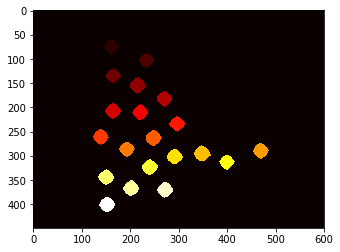

In [6]:
plt.imshow(label_objects, cmap='hot')


def cog(labelledImage, objNumber):
    cx = 0
    cy = 0
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y, x] == objNumber:
                cy = cy + y
                cx = cx + x

    cx = cx / sizes[objNumber]
    cy = cy / sizes[objNumber]

    return int(cy), int(cx)


cogs = []
for i in range(nb_labels):
    cogs.append(cog(label_objects, i+1))

print(cogs)


 ##### Narysowanie środków ciężkości na objects na obrazie

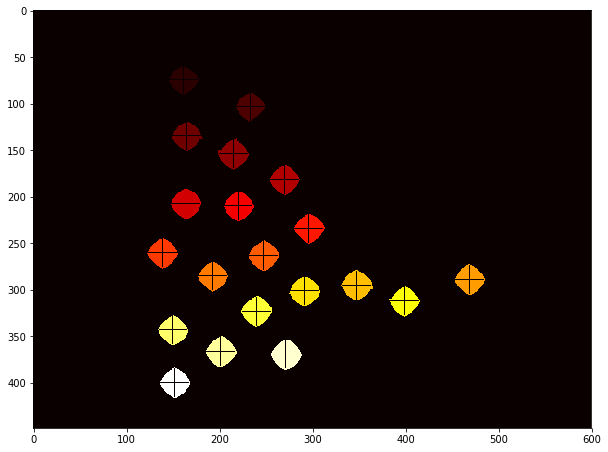

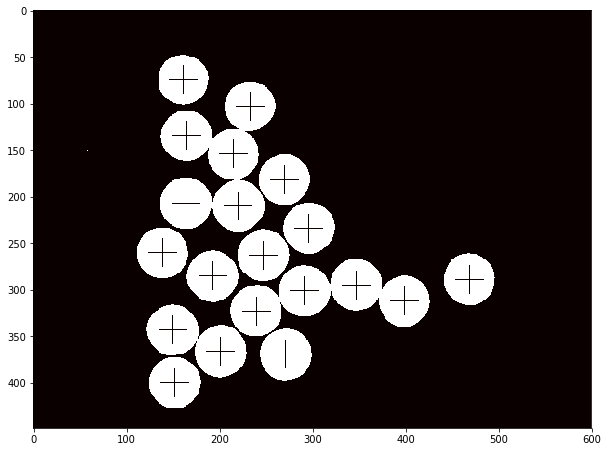

In [7]:


def drawMarkers(image, coords):

    image = np.copy(image)

    for item in coords:
        y, x = item
        for j in range(y-15, y+16):
            image[j, x] = 0
        for i in range(x-15, x+16):
            image[y, i] = 0

    return image


# Po erozji
lo = drawMarkers(label_objects, cogs)
plt.figure(figsize=(10, 10))
plt.imshow(lo, cmap='hot')
plt.show()

# Przed erozją
lo = drawMarkers(binary, cogs)
plt.figure(figsize=(10, 10))
plt.imshow(lo, cmap='hot')
plt.show()


 ##### Obliczanie wielkości każdego obiektu (po erozji) oraz współczynników Blair-Bliss-a i Feret-a

In [8]:


def cog2(points):
    mx = 0
    my = 0
    for (y, x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)

    return [my, mx]


def computeBB(points):

    s = len(points)
    my, mx = cog2(pts)

    r = 0
    for point in points:
        r = r + distance.euclidean(point, (my, mx))**2

    return s/(math.sqrt(2*math.pi*r))


def computeFeret(points):

    px = [x for (y, x) in points]
    py = [y for (y, x) in points]

    fx = max(px) - min(px)
    fy = max(py) - min(py)

    return float(fy)/float(fx)


sum_after_erosion = 0

for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    sum_after_erosion += len(pts)
    percent = len(pts)/(image.shape[0]*image.shape[1])*100
    bb = computeBB(pts)
    feret = computeFeret(pts)

    print('Liczba punktow (po erozji):', len(pts), '- {:.2f} %'.format(percent),
          'Srodek ciezkosci: [{0[1]:.2f}, {0[1]:.2f}]'.format(cog2(pts)),
          'Blair-Bliss: {:.4f}'.format(bb), 'Feret: {:.4f}'.format(feret))

print('\nSuma punktów obiektów po erozji:', sum_after_erosion, ', różnica (ubytek): ',
      (number_of_points - sum_after_erosion)/number_of_points*100, '%')


Liczba punktow (po erozji): 641 - 0.24 % Srodek ciezkosci: [161.44, 161.44] Blair-Bliss: 0.9958 Feret: 0.9677
Liczba punktow (po erozji): 621 - 0.23 % Srodek ciezkosci: [233.13, 233.13] Blair-Bliss: 0.9938 Feret: 0.9677
Liczba punktow (po erozji): 660 - 0.24 % Srodek ciezkosci: [165.13, 165.13] Blair-Bliss: 0.9937 Feret: 0.9091
Liczba punktow (po erozji): 701 - 0.26 % Srodek ciezkosci: [215.08, 215.08] Blair-Bliss: 0.9928 Feret: 1.0312
Liczba punktow (po erozji): 675 - 0.25 % Srodek ciezkosci: [270.15, 270.15] Blair-Bliss: 0.9957 Feret: 1.0000
Liczba punktow (po erozji): 724 - 0.27 % Srodek ciezkosci: [164.42, 164.42] Blair-Bliss: 0.9967 Feret: 1.0000
Liczba punktow (po erozji): 699 - 0.26 % Srodek ciezkosci: [220.92, 220.92] Blair-Bliss: 0.9947 Feret: 1.0000
Liczba punktow (po erozji): 680 - 0.25 % Srodek ciezkosci: [296.89, 296.89] Blair-Bliss: 0.9943 Feret: 0.9688
Liczba punktow (po erozji): 697 - 0.26 % Srodek ciezkosci: [139.13, 139.13] Blair-Bliss: 0.9964 Feret: 1.0000
Liczba pun